In [126]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import CubicSpline

# Incline Walking
t_rise = 15		    # stance from t_peak
t_peak = 54		    # stance from heel strike
t_fall = 12		    # stance from t_peak
t_toe_off = 67		# stance from heel strike

END_OF_STANCE = t_toe_off
END_OF_STRIDE = 100

holding_torque = 2

In [127]:
def convert_percent_stride_thresholds_to_stance_times(stance_period:float)->list:
    """Converts 4ptSpline thresholds from units of % stride to seconds within the current stance phase
    using the average stance period

    args:
        None
    
    returns:
        stance_t_peak: time of peak torque in current stance
        stance_t_toe_off: time of toe off in current stance
        stance_t_onset: time of torque onset in current stance
        stance_t_dropoff: time of torque dropoff in current stance
    """
    # scale the thresholds from in terms of % stride to % stance:
    stance_t_peak = t_peak / END_OF_STANCE * stance_period
    stance_t_rise = t_rise / END_OF_STANCE * stance_period
    stance_t_fall = t_fall  / END_OF_STANCE * stance_period
    stance_t_toeoff = t_toe_off / END_OF_STANCE * stance_period

    # calculate time of torque onset and dropoff
    stance_t_onset = stance_t_peak - stance_t_rise
    stance_t_dropoff = stance_t_peak + stance_t_fall

    return [stance_t_onset, stance_t_peak, stance_t_dropoff, stance_t_toeoff]

def convert_percent_thresholds_to_time(stride_period:float)->list:
    """Converts 4ptSpline thresholds from units of % stride to seconds within the current 
    stride using the average stride period

    args:
        None
    
    returns:
        stride_t_peak: time of peak torque in current stride
        stride_t_toe_off: time of toe off in current stride
        t_onset: time of torque onset in current stride
        t_dropoff: time of torque dropoff in current stride
    """
    
    # Convert Nodes to % stride
    stride_t_peak = t_peak / END_OF_STRIDE * stride_period
    stride_t_rise = t_rise / END_OF_STRIDE * stride_period
    stride_t_fall = t_fall / END_OF_STRIDE * stride_period
    stride_t_toe_off = t_toe_off / END_OF_STRIDE * stride_period

    # calculate time of torque onset and dropoff
    stride_t_onset = stride_t_peak - stride_t_rise
    stride_t_dropoff = stride_t_peak + stride_t_fall

    return [stride_t_onset, stride_t_peak, stride_t_dropoff, stride_t_toe_off]
        

In [128]:
def torque_generator_MAIN(time_in_current_stride:float, stride_period:float, peak_torque:float, in_swing_flag:bool)->float:
    """Generate torque curve based on current time in stride.
    args:
        time_in_current_stride: time since last HS
        stride_period: average stride period
        peak_torque: peak torque commanded by user via GUI
    
    returns:
        torque: torque value at current time in stride
    """

    time_nodes = convert_percent_thresholds_to_time(stride_period)
    stride_t_onset = time_nodes[0]
    stride_t_peak = time_nodes[1]
    stride_t_dropoff = time_nodes[2]
    # stride_t_toe_off = time_nodes[3]
            
    if in_swing_flag:
        output_torque = holding_torque
    else:
        if (time_in_current_stride > 0) and (time_in_current_stride <= stride_t_onset):
            # linear ramp from 0 to holding torque ~ output_torque = ( (holding_torque - 0) /(stride_t_onset - 0)) * time_in_current_stride 
            output_torque = holding_torque 
            
        elif (time_in_current_stride > stride_t_onset) and (time_in_current_stride <= stride_t_peak):
            torques = [holding_torque, float(peak_torque)]
            t_nodes = [stride_t_onset, stride_t_peak]
            
            # Rising spline until peak time
            rising_spline = CubicSpline(t_nodes, torques,bc_type='clamped')  
            output_torque =  rising_spline(time_in_current_stride)    

        elif (time_in_current_stride > stride_t_peak) and (time_in_current_stride <= stride_t_dropoff):
            torques = [float(peak_torque), holding_torque]
            t_nodes = [stride_t_peak, stride_t_dropoff]
            
            # Falling spline until offset time
            falling_spline = CubicSpline(t_nodes, torques,bc_type='clamped')
            output_torque =  falling_spline(time_in_current_stride)      
            
            # y_intercept = output_torque 
            # previous_time = time_in_current_stride
        else:
            # either less than 0% or greater than toe-off (including swing if misclassified)
            output_torque = holding_torque
        
    return output_torque
    
def torque_generator_stance_MAIN(time_in_current_stance:float, stride_period:float=1.12, stance_period:float=0.65, peak_torque:float=2, in_swing:bool=False)->float:
    """Generate torque curve based on current time in stance. Torque is held at holding torque when in_swing_flag is tripped, otherwise
    exo actuates according to thresholds set in terms of stance phase.
    
    args:
        time_in_current_stance: time since last HS
        stance_period: average stance period
        peak_torque: peak torque commanded by user via GUI
        in_swing_flag: boolean flag for swing phase
    
    returns:
        torque: torque value at current time in stride
    """
    time_nodes = convert_percent_stride_thresholds_to_stance_times(stance_period)       
    stance_t_onset = time_nodes[0]
    stance_t_peak = time_nodes[1]
    stance_t_dropoff = time_nodes[2]
    
    if peak_torque < holding_torque:
        peak_torque = holding_torque
            
    if (in_swing):
        output_torque = holding_torque
    else:
        if (time_in_current_stance > 0) and (time_in_current_stance <= stance_t_onset):
            output_torque = holding_torque
            
        elif (time_in_current_stance > stance_t_onset) and (time_in_current_stance <= stance_t_peak):
            # Only regen spline object when torque is changed, otherwise just eval using same object
            # if prev_commanded_rising != peak_torque:
            torques = [holding_torque, float(peak_torque)]
            t_nodes = [stance_t_onset, stance_t_peak]
                
            # Rising spline until peak time
            rising_spline = CubicSpline(t_nodes, torques,bc_type='clamped')   
            # prev_commanded_rising = peak_torque
                
            output_torque =  rising_spline(time_in_current_stance) 

        elif (time_in_current_stance > stance_t_peak) and (time_in_current_stance <= stance_t_dropoff):
            # if prev_commanded_falling != peak_torque:
            torques = [float(peak_torque), holding_torque]
            t_nodes = [stance_t_peak, stance_t_dropoff]
            
            # Falling spline until offset time
            falling_spline = CubicSpline(t_nodes, torques,bc_type='clamped')
            # prev_commanded_falling = peak_torque
            
            output_torque =  falling_spline(time_in_current_stance)      
            
        else:
            # either less than 0% or greater than toe-off (including swing if misclassified)
            output_torque = holding_torque
            
        # Catch any instances of output torque being less than holding torque as a safety
        # i.e. when GUI commanded torque is first '0'
        if output_torque < holding_torque:
            output_torque = holding_torque
        
    return output_torque

Validate Assistance Profiles

In [129]:
p_ranges = np.linspace(0, 100, 1001)
torque_ranges = np.linspace(5, 40, 8)

stride_period = 1.0
stance_period = t_toe_off/100 * stride_period

baseline_profile_stride = []
baseline_profile_stance = []

stride_profiles = dict()
stance_profiles = dict()
for T in torque_ranges:
    temp_profile_stride = []
    temp_profile_stance = []
    for p in p_ranges:
        current_time_stride = p/100 * stride_period
        current_time_stance = p/100 * stance_period
        temp_profile_stride.append(torque_generator_stance_MAIN(current_time_stride, stride_period, stance_period, T, False))
        temp_profile_stance.append(torque_generator_MAIN(current_time_stance, stride_period, T, False))
    stride_profiles[T] = temp_profile_stride
    stance_profiles[T] = temp_profile_stance

    if T == 40:
        baseline_profile_stride = temp_profile_stride
        baseline_profile_stance = temp_profile_stance
    

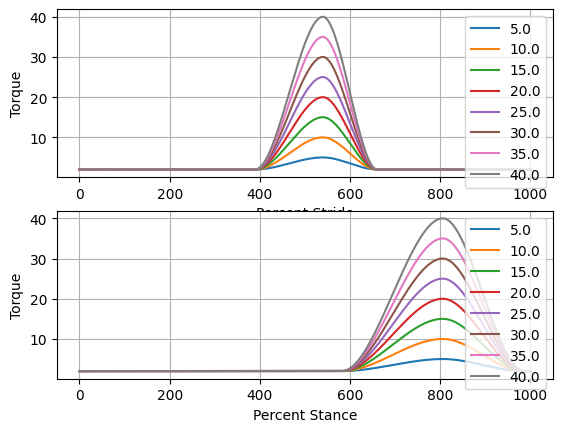

In [130]:
fig, [ax1, ax2] = plt.subplots(2, 1)
for T in torque_ranges:
    ax1.plot(stride_profiles[T], label=T)
    ax2.plot(stance_profiles[T], label=T)
ax1.set_xlabel('Percent Stride')
ax2.set_xlabel('Percent Stance')
ax1.set_ylabel('Torque')
ax2.set_ylabel('Torque')

ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
plt.show()

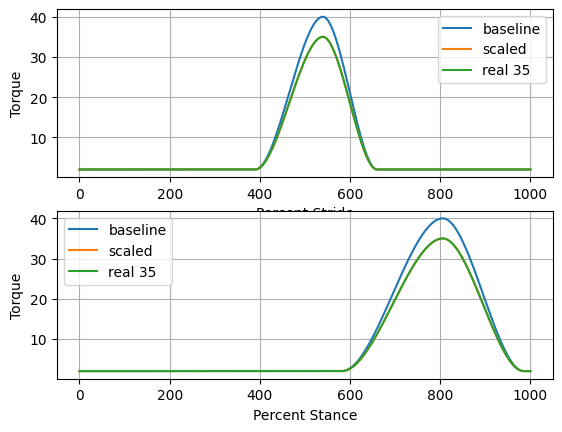

1.4785231426651057e-29


In [131]:
"""
Why scaling the cubic spline works:

https://math.stackexchange.com/questions/4616667/equivalence-classes-of-polynomials-under-function-transformations

Cubic spline being generated has same critical points, so we can get any other cubic spline from a single example by scaling/translating

Only need to linearly scale the torque to get the exact same result if we were to regenerate the cubicspline through equation/function

"""


# Linear scaling of y bounds
def scale_to(x, min_base, max_base, min_new, max_new):
    return (max_new - min_new) / (max_base - min_base) * (x - min_base) + min_new

# Create base profile
base_stride = [scale_to(t, 2, 40, 0, 100) for t in baseline_profile_stride]
base_stance = [scale_to(t, 2, 40, 0, 100) for t in baseline_profile_stance]

# Scale profile to correct torque bounds
holding_torque = 2
peak_T = 35
scaled_stride = [scale_to(t, 0, 100, holding_torque, peak_T) for t in base_stride]
scaled_stance = [scale_to(t, 0, 100, holding_torque, peak_T) for t in base_stance]

# Plot against Cubicspline result
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(baseline_profile_stride, label='baseline')
ax1.plot(scaled_stride, label='scaled')
ax1.plot(stride_profiles[peak_T], label='real {}'.format(peak_T))

ax2.plot(baseline_profile_stance, label='baseline')
ax2.plot(scaled_stance, label='scaled')
ax2.plot(stance_profiles[peak_T], label='real {}'.format(peak_T))

ax1.set_xlabel('Percent Stride')
ax2.set_xlabel('Percent Stance')
ax1.set_ylabel('Torque')
ax2.set_ylabel('Torque')

ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
plt.show()

# MSE
print(np.square(np.subtract(scaled_stride, stride_profiles[peak_T])).mean())

# Generic Profile Test

1) Create generic profile with time ranges [0, 1] and torque ranges [0, 1]
2) Using generic profile, test using stride_period and peak_torque to generate torque commands over time

In [151]:
def get_generic_profile(granularity=10000):
    """
    Creates generic cubic spline based profile using timing parameters
    percent range: [0, 1]
    torque range: [0, 1]

    sets generic_profile dictionary as attribute of class
    
    dictionary is size granularity indexed by ints from 0 to granularity
    """

    # Torque range
    t_min = 0
    t_max = 1

    # Convert Nodes to % stride
    p_peak = t_peak / END_OF_STRIDE
    p_rise = t_rise / END_OF_STRIDE
    p_fall = t_fall / END_OF_STRIDE
    # p_toe_off = self.t_toe_off / END_OF_STRIDE

    # Calculate time of torque onset and dropoff
    p_onset = p_peak - p_rise
    p_dropoff = p_peak + p_fall
    
    # Dictionary indices
    p_range = np.linspace(0, 1, 1001)

    # Spline sections
    rising_spline = CubicSpline([p_onset, p_peak], [t_min, t_max], bc_type='clamped')
    falling_spline = CubicSpline([p_peak, p_dropoff], [t_max, t_min],bc_type='clamped')

    generic_profile = {}
    for p in range(granularity):
        percent = p/granularity
        if (percent > 0) and (percent <= p_onset):
            # Onset
            output_torque = t_min
        elif (percent > p_onset) and (percent <= p_peak):
            # Rising
            output_torque = rising_spline(percent)
        elif (percent > p_peak) and (percent <= p_dropoff):
            # Falling
            output_torque =  falling_spline(percent)
        else:
            output_torque = t_min
    
        generic_profile[p] = output_torque

    return generic_profile

def scale_torque(torque, min_base, max_base, min_new, max_new):
    return (max_new - min_new) / (max_base - min_base) * (torque - min_base) + min_new

def get_generic_torque_command(percent_stride, generic_profile, granularity):
    """
    Evaluate generic_profile at percent_stride

    convert percent_stride nearest integer index

    less error from int casting by increasing granularity
    """
    generic_index = min(int(percent_stride * granularity), granularity-1)
    return generic_profile[generic_index]

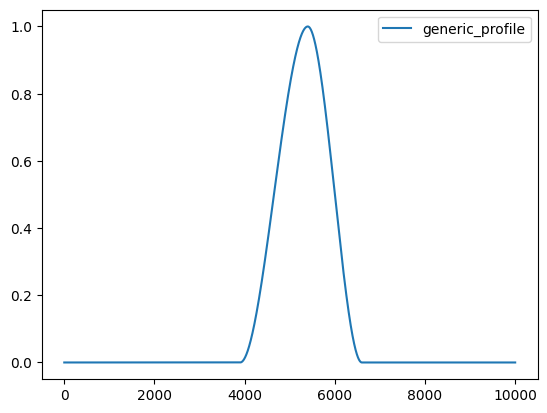

In [152]:
granularity = 10000
generic_profile = get_generic_profile(granularity=granularity)

generic_profile_torques = [generic_profile[p] for p in range(granularity)]

fig, ax = plt.subplots()

ax.plot(generic_profile_torques, label='generic_profile')
ax.legend()
plt.show()


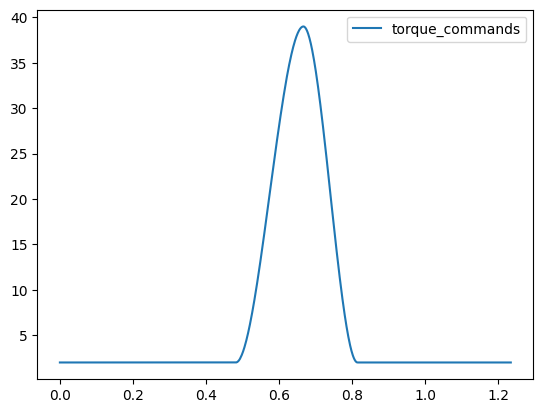

In [153]:
# Random settings
stride_period = 1.234
peak_torque = 39


t_ranges = np.linspace(0, stride_period, 1000)

torque_commands = []
for t in t_ranges:
    percent_stride = t / stride_period

    generic_command = get_generic_torque_command(percent_stride, generic_profile, granularity)

    torque = scale_torque(generic_command, 0, 1, holding_torque, peak_torque)

    torque_commands.append(torque)

fig, ax = plt.subplots()

ax.plot(t_ranges, torque_commands, label='torque_commands')
ax.legend()
plt.show()